# Predicting Working Hours 

### DAT 402: Project 1 
### Author: Tristan McCoy

## Introduction

This machine learning project aims to predict the average annual working hours per worker (referred to as 'working hours' hereafter) for a Western country based on a given GDP per capita (reffered to as 'GDP' hereafter). I will utilize a KNN regression algorithm to achieve this. In addition to using the KNN regression algorithm, I also utilized a Ridge regression model and compare the results as well as comparing the best model's performance on the training and testing data. 

This project will employ a dataset that includes various countries' GDP and working hours from 1950 to 2019. I will train the KNN regression model on a portion of the dataset and test its performance on the remaining portion to evaluate its accuracy. To perform the comparison, I divided the dataset into training and testing sets and trained both the KNN and Ridge regression models on the training data. I then evaluate the models' performance on the testing data by calculating the root mean squared error (RMSE) and R-squared (R2) scores.


### Inspiration

This project was chosen due to the increasing number of Americans advocating for a shorter workweek. Many believe that reducing the number of working hours will improve work-life balance, increase productivity, and decrease stress levels. While a shorter workweek has its advantages, it is important to understand its potential impact on the economy and how it relates to a country's overall GDP. This machine learning project can help shed light on the relationship between GDP and working hours. If the project's results indicate that countries with higher GDP tend to have less working hours, it may provide insights into the potential economic impact of implementing a shorter workweek and provide insights to policymakers for making informed decisions.


#### Source: https://ourworldindata.org/working-hours


In [1]:
# import necessary libararies
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sklearn
import os

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge


In [2]:
# Read data 
pwd = os.getcwd()

data = pd.read_csv(pwd + '/hours-v-gdp.csv')

## Data wrangling 
#### Selection process
In this project, countries from North America, Europe, and Oceania are chosen for the analysis because they have similar economic structures. This choice was made to minimize the potential impact of economic and cultural differences between countries on the analysis.

Western countries and neighbors are often classified as developed economies with similar labor market institutions, social policies, and cultural values. They also share similar industries and trade patterns, which can provide a more homogeneous dataset for analysis.

By focusing on these countries, we can reduce the potential for confounding variables and improve the accuracy of our analysis. This approach can also help in making more accurate predictions and provide more valuable insights into the relationship between GDP and working hours.

In [3]:
# choose countries to use in the model 
countries = ['Austria','Belgium','Bulgaria', 'Croatia', 'Cyprus', 'Czechia', 'Denmark', 'Estonia', 'Finland', 
             'France', 'Germany', 'Greece', 'Hungary', 'Iceland', 'Ireland', 'Italy', 'Latvia', 'Lithuania', 
             'Luxembourg', 'Malta', 'Netherlands', 'Norway', 'Poland', 'Portugal', 'Romania', 'Russia', 
             'Slovakia', 'Slovenia', 'Spain', 'Sweden','Switzerland', 'United Kingdom', 'United States', 
             'Canada', 'Mexico', 'Costa Rica', 'Australia', 'New Zealand', 'Dominican Republic']

data_filtered = data[data['Entity'].isin(countries)]

# check columns for potential indicators
data_filtered

,Entity,Code,Year,Annual working hours per worker,"GDP per capita (output, multiple price benchmarks)",Population (historical estimates),Continent
2975,Australia,AUS,0,NaN,NaN,250005.0,NaN
2976,Australia,AUS,100,NaN,NaN,250009.0,NaN
2977,Australia,AUS,200,NaN,NaN,250013.0,NaN
2978,Australia,AUS,300,NaN,NaN,250020.0,NaN
2979,Australia,AUS,400,NaN,NaN,250030.0,NaN
...,...,...,...,...,...,...,...
52848,United States,USA,2017,1763.7267,60116.570,329791232.0,NaN
52849,United States,USA,2018,1774.7039,61618.742,332140032.0,NaN
52850,United States,USA,2019,1765.3464,62589.000,334319680.0,NaN
52851,United States,USA,2020,NaN,NaN,335942016.0,NaN


In [4]:
# remove unnecessary data columns
df = data_filtered.drop(columns = ['Code', 'Continent'])

# indentify missing values 
df.isna().sum()

Entity                                                   0
Year                                                     0
Annual working hours per worker                       7706
GDP per capita (output, multiple price benchmarks)    7365
Population (historical estimates)                        0
dtype: int64

In [5]:
# remove missing values 
df = df.dropna()

# reset indeces
df = df.reset_index(drop = True)

In [6]:
# rename columns for ease
df = df.rename(columns = {'Entity': 'Country', 'Annual working hours per worker': 'Hours',
                         'GDP per capita (output, multiple price benchmarks)': 'GDP',
                         'Population (historical estimates)': 'Population'})

# sanity check
df.head()

,Country,Year,Hours,GDP,Population
0,Australia,1950,2170.9233,13660.783,8177169.0
1,Australia,1951,2150.8470,12852.690,8419836.0
2,Australia,1952,2130.9560,12414.002,8632790.0
3,Australia,1953,2111.2493,13721.202,8819163.0
4,Australia,1954,2091.7246,14403.238,9003364.0


## Exploratory data analysis

In [7]:
# isolate trends for the usa, uk, and germany 
US = df[df['Country'] == 'United States']
UK = df[df['Country'] == 'United Kingdom']
DE = df[df['Country'] == 'Germany']
IR = df[df['Country'] == 'Ireland']

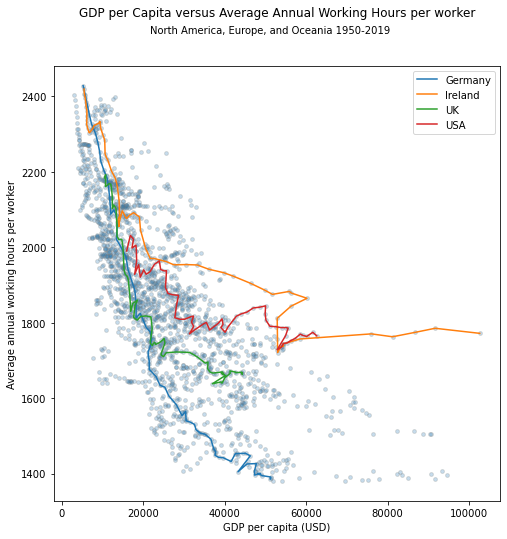

In [8]:
# plot gdp versus working hours showcasing three countries with varying trajectories 
plt.figure(figsize = (8, 8))

plt.scatter(df['GDP'], df['Hours'], s = 15, alpha = 0.25, edgecolor = 'grey')
plt.plot(DE['GDP'], DE['Hours'], label = 'Germany')
plt.plot(IR['GDP'], IR['Hours'], label = 'Ireland')
plt.plot(UK['GDP'], UK['Hours'], label = 'UK')
plt.plot(US['GDP'], US['Hours'], label = 'USA')

plt.title('GDP per Capita versus Average Annual Working Hours per worker', y = 1.1)
plt.suptitle('North America, Europe, and Oceania 1950-2019', y = 0.95, fontsize = 10)
plt.xlabel('GDP per capita (USD)')
plt.ylabel('Average annual working hours per worker')

plt.legend(loc = 'upper right')

plt.show()

## KNN Regression

#### Select train and test data

In [9]:
# choose the indicators (x) and what to predict (y)
X = df[['GDP']]
y = df['Hours']

# select training and testing sets for x and y
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 75, test_size = 0.3)


In KNN regression, scaling the data is important to ensure that all variables have equal weight in the model's predictions. However, when variables have large numbers, they can dominate the scaled data, leading to imbalanced weighting in the model's predictions and a lower R-squared score. To address these issues, it may be necessary to standardize the data before applying KNN regression. This can help to reduce the impact of large numbers in the dataset and improve the accuracy of the KNN regression model.


#### Scale predictors for the model

In [10]:
# create a scaler 
scaler = StandardScaler()

# fit the scaler to x train data
scaler.fit(X_train)

# scale x train and x test values
X_train_sc = scaler.transform(X_train)
X_test_sc = scaler.transform(X_test)

#### Implement cross-validation

In [11]:
# create a 10-fold cross-validation model for choosing optimal k value
grid_search = GridSearchCV(KNeighborsRegressor(), {'n_neighbors': range(1, 101)}, cv = 10)

# fit x and y train data to the cv model
grid_search.fit(X_train_sc, y_train)

# choose optimal k value
k_best = grid_search.best_params_['n_neighbors']

print('Optimal k: ', k_best)

Optimal k:  66


#### Create the model

In [12]:
# create a knn model using optimal k
model = KNeighborsRegressor(n_neighbors = k_best)

# fit the knn model to the x and y train data  
model.fit(X_train_sc, y_train)

# define a helper function to predict outputs from the training and testing data using the knn model
def predict(data):
    return(model.predict(data))


## Ridge regression

In [13]:
params = {'alpha': range(1,101)}

# create a cross-validation model for choosing optimal alpha 
ridge_cv = GridSearchCV(Ridge(), params, cv=10)

# fit the cv model to the x and y train data 
ridge_cv.fit(X_train_sc, y_train)

# choose best alpha
alpha_best = ridge_cv.best_params_['alpha']

print('Optimal alpha: ', alpha_best)

# create ridge model
ridge = Ridge(alpha=alpha_best)

# fit the ridge model to the x and y train data  
ridge.fit(X_train_sc, y_train)

# predict y values from x test values using ridge model
# store them in ridge_preds for later use
ridge_preds = ridge.predict(X_test_sc)


Optimal alpha:  13


## Compare results 

The results show that the KNN model outperforms the Ridge model on the basis of the R-squared score and the root mean squared error. 

Additionally, the KNN model slightly outperforms on the training data than the testing data which suggests that the model slightly overfits the data.

### KNN performance
#### Train data

In [14]:
print('R-Squared: ', r2_score(y_train, predict(X_train_sc)))
print('RMSE: ', np.sqrt(mean_squared_error(y_train, predict(X_train_sc))))

R-Squared:  0.6247888374180839
RMSE:  139.35425367917952


#### Test data

In [15]:
print('R-Squared: ', r2_score(y_test, predict(X_test_sc)))
print('RMSE: ', np.sqrt(mean_squared_error(y_test, predict(X_test_sc))))

R-Squared:  0.5829114697793882
RMSE:  147.23979898075103


### Ridge performance

In [16]:
print('R-Squared: ', r2_score(y_test, ridge_preds))
print('RMSE: ', np.sqrt(mean_squared_error(y_test, ridge_preds)))

R-Squared:  0.4714461083413112
RMSE:  165.75083683412464


## Visualize results

#### R-squared scores for all k values in the model

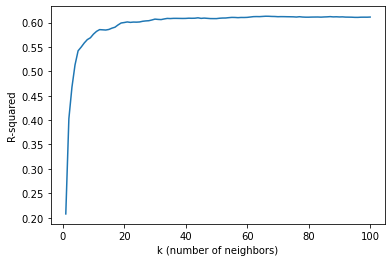

In [17]:
r_squared = grid_search.cv_results_['mean_test_score']

plt.plot(range(1, 101), r_squared)
plt.xlabel('k (number of neighbors)')
plt.ylabel('R-squared')

plt.show()

#### Plot the performance of the train and test models

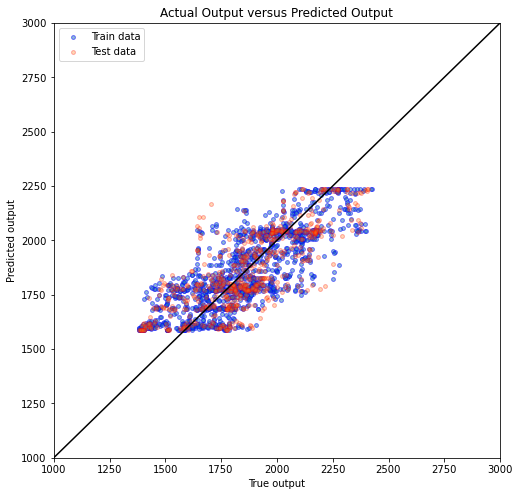

In [18]:
plt.figure(figsize = (8, 8))

plt.scatter(y_train, predict(X_train_sc), s = 15, alpha = 0.5, edgecolor = 'blue', label = 'Train data')
plt.scatter(y_test, predict(X_test_sc), s = 15, alpha = 0.3, edgecolor = 'red', label = 'Test data')
plt.axline((0, 0), slope = 1, color = 'black')

plt.title('Actual Output versus Predicted Output')
plt.xlabel('True output')
plt.ylabel('Predicted output')
plt.xlim(1000, 3000)
plt.ylim(1000, 3000)

plt.legend(loc = 'upper left')

plt.show()

#### Plot the KNN model using the training data

In [19]:
# create a new dataframe for the train data and predictions
model_train = pd.DataFrame()

# store train data and predictions 
model_train['GDP'] = X_train['GDP']
model_train['Hours'] = predict(X_train_sc)

# sort the train model for visualization
model_train = model_train.sort_values('GDP')

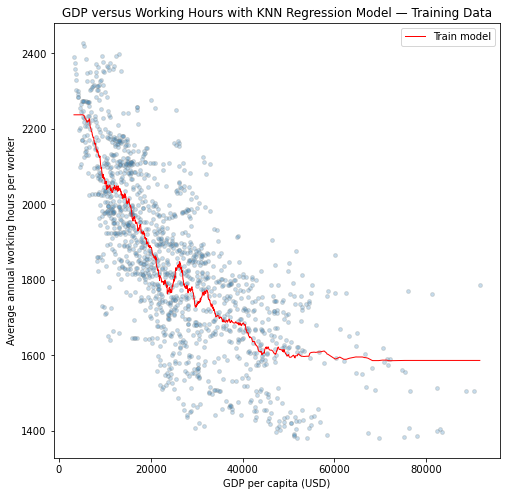

In [20]:
plt.figure(figsize = (8, 8))

plt.scatter(X_train['GDP'], y_train, s = 15, alpha = 0.25, edgecolor = 'grey')
plt.plot(model_train['GDP'], model_train['Hours'], color = 'red', lw = 1, label = 'Train model')

plt.title('GDP versus Working Hours with KNN Regression Model — Training Data')
plt.xlabel('GDP per capita (USD)')
plt.ylabel('Average annual working hours per worker')

plt.legend(loc = 'upper right')

plt.show()

#### Plot the KNN model using the testing data

In [21]:
# create a new dataframe for the test data and predictions
model_test = pd.DataFrame()

# store test data and predictions
model_test['GDP'] = X_test['GDP']
model_test['Hours'] = predict(X_test_sc)

# sort the test model for visualization
model_test = model_test.sort_values('GDP')

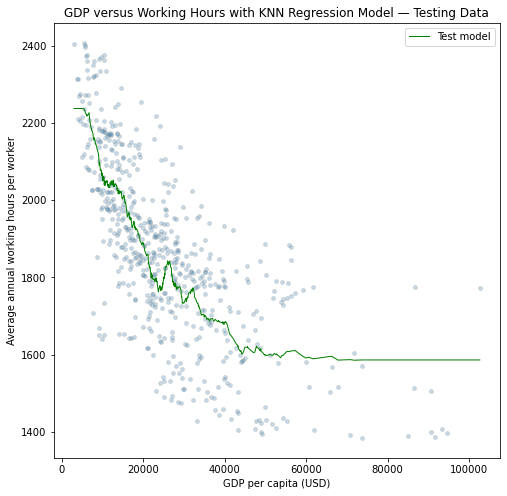

In [22]:
plt.figure(figsize = (8, 8))

plt.scatter(X_test['GDP'], y_test, s = 15, alpha = 0.25, edgecolor = 'grey')
plt.plot(model_test['GDP'], model_test['Hours'], color = 'green', lw = 1, label = 'Test model')

plt.title('GDP versus Working Hours with KNN Regression Model — Testing Data')
plt.xlabel('GDP per capita (USD)')
plt.ylabel('Average annual working hours per worker')

plt.legend(loc = 'upper right')

plt.show()

### Predictions

Let's use the KNN model to predict the working hours for the US in 2019 and compare it with the observed value in the data set. Will it be less?

Let's also predict the working hours in the US for 2020 and 2021. The GDP per capita for those years are:

2020: $63,530

2021: $70,249

#### Source: https://data.worldbank.org/indicator/NY.GDP.PCAP.CD?locations=US

In [23]:
# create a dataframe to store the predictors for each year
predictions = pd.DataFrame()

# Indeces 0, 1, and 2 correspond to 2019, 2020, and 2021, respectively
predictions['GDP'] = [US[US['Year'] == 2019]['GDP'].values[0], 63530, 70249]

# scale the predictors to the model
predictions = scaler.transform(predictions)

# print results
print('Observed US working hours for 2019: ', round(US[US['Year'] == 2019]['Hours'].values[0], 2))
print('Predicted US working hours for 2019: ', round(model.predict([predictions[0]])[0], 2))
print('Predicted US working hours for 2020: ', round(model.predict([predictions[1]])[0], 2))
print('Predicted US working hours for 2021: ', round(model.predict([predictions[2]])[0], 2))

Observed US working hours for 2019:  1765.35
Predicted US working hours for 2019:  1589.33
Predicted US working hours for 2020:  1594.37
Predicted US working hours for 2021:  1585.81


## Remarks 

#### Outliers
The greater disparity in working hours as GDP increases is a phenomenon that is commonly observed in many developed countries. In these countries, as the economy grows, the labor market becomes more specialized leading to higher-paying jobs that typically require longer working hours. In other cases, some countries may have vastly lower working hours than other countries with similar GDPs. Ireland and Germany are examples of these phenomena, respectively. 
These data points could be considered outliers in the dataset. Since outliers have significantly different values than other countries in the dataset, they may receive a disproportionate amount of weight in the model's predictions which can also lead to errors in the model's predictions and a lower R-squared score. In this context, however, the model could be seen as an attempt to find a balance between this disparity.

#### Bias 

This disparity in working hours can potentially introduce bias in the model's predictions, as the model may not capture the relationship between GDP and working hours accurately. To address these issues, it is important to incorporate additional variables that may influence the relationship between GDP and working hours as well as removing or adjusting the outlier values in the dataset or use other modeling techniques that are less sensitive to outliers. One such variable could be population size since it influcences GDP.

Another potential source of bias in this machine learning model is selection bias. Selection bias can arise if the Western countries included in the analysis are not representative of all countries globally. This bias can lead to inaccurate predictions and limit the model's generalizability to other countries and regions. It is also essential to evaluate the model's predictions and analyze the model's performance on different subgroups of the population to identify any potential biases. This evaluation can help identify any patterns or trends that may be indicative of selection bias or other sources of bias in the model.


## Conclusion

The results of the comparison showed that the KNN regression model outperformed the Ridge regression model in predicting the average annual working hours based on the GDP. The KNN model had a lower RMSE and a higher R2 score, indicating that it provided a more accurate prediction than the Ridge regression model.

An R-squared score of 58% for the KNN model indicates that the model explains 58% of the variability in the dependent variable, based on the independent variables included in the model. While this may not seem high, it still suggests that the model has some predictive power and can be useful for making generalized predictions. The remaining 42% is likely due to other factors that are not accounted for in the model.
